<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/Event_NoEvent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf
from keras.models import Model
!pip install tensorflow_addons
!pip install keras-tuner -q

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [51]:
# load dataset using pickle
import pickle
with open("/content/drive/MyDrive/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [52]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])
    df['Time'] = d['time']
    df['Frame'] = range(0, 20)

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:20]

      #Assign labels to closest points
      df['Label'] = 0
      df.loc[closest_indices, 'Label'] = label
    else:
      df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
      # Append the current DataFrame to the main DataFrame
      df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()
display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

base_col = df_data.columns

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Frame,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10043.250,10.361,0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,9893.750,10.362,1,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,11016.000,10.363,2,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10170.375,10.364,3,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,8967.750,10.365,4,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,6837.500,8.622,15,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,4885.750,8.623,16,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,6152.000,8.624,17,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,2765.500,8.625,18,0,98005,905


Labels count:
0    12840
1     4140
2     1000
Name: Label, dtype: int64


In [53]:
df_data['Label'] = df_data['Label'].replace(2, 1)

In [54]:
#make a for loop per shot
shots = df_data['Shot'].unique()
#add a column to the dataframe called order
df_data['Order'] = 0
for shot in shots :
    #take frame 0
    df_shot = df_data[df_data['Shot'] == shot]
    df_shot = df_shot[df_shot['Frame'] == 0]
    #take the time of the frame 0
    time = df_shot['Time'].values

    for l in range (len(time)):
        #take the index in the data of the smallest time
        index = df_shot['Time'].idxmin()
        #set the order column of the index to 1
        df_data.loc[index, 'Order'] = l
        #set the order to the next 18 rows
        for i in range(1, 20):
            df_data.loc[index+i, 'Order'] = l
        #drop the value of the time array so the next smallest value will be taken
        df_shot = df_shot.drop(index)


def process_shot_group(group):
    minor_event_tracker = 0
    minor_events = []
    #sort by order column
    group = group.sort_values(by=['Order'])

    for i in group.index[::20]:  # Iterate over the index, stepping by 20
        minor_events.extend([minor_event_tracker] * 20)


        if group.at[i, 'Label'] == 1:  # Check the label at every 20th row
            minor_event_tracker += 1

    group['Instability'] = minor_events
    return group

# Apply the function to each 'Shot' group
grouped_df = df_data.groupby('Shot').apply(process_shot_group).reset_index(drop=True)
# Display the result
grouped_df = grouped_df.groupby(by=['Shot', 'Order'], group_keys=False).apply(lambda x: x.sort_values(by=['Frame'])).reset_index(drop=True)

# Drop rows where 'ZMAG' has negative values
grouped_df = grouped_df[grouped_df['ZMAG'] >= 0]


In [55]:
columns_to_multiply = [col for col in grouped_df.columns if col != 'Label']
columns_to_multiply.remove('Vloop')
columns_to_multiply.remove('Shot')

# Now we will iterate over pairs of columns and create new columns for each pairing
for i, col1 in enumerate(columns_to_multiply):
    for col2 in columns_to_multiply[i+1:]:
        # Create a new column name based on the two column names
        new_col_name = f'log({col1}_x_{col2})'

        # PLaceholder
        df = pd.DataFrame()

        # Calculate the product of the two columns and assign to the new column
        df[new_col_name] = np.log(grouped_df[col1] * grouped_df[col2] + 1e-10)

        # Add to original DataFrame
        grouped_df = pd.concat([grouped_df, df], axis=1)

df_data = grouped_df.copy()

# Compute the correlation matrix
correlations = df_data.corr()

# Sort by the absolute values of the correlations with 'Label'
sorted_correlations = correlations['Label'].abs().sort_values(ascending=False)

# Get the top 2 most correlated columns (excluding 'Label' itself) and add them to the original dataframe
top_2_correlated = sorted_correlations[1:3]
all_col = base_col.append(top_2_correlated.index)

df_data = df_data[all_col]
print(df_data.columns)
df_data = df_data.drop(columns=['Frame'])

Index(['IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop',
       'IPE', 'Time', 'Frame', 'Label', 'Shot', 'Window',
       'log(IPLA_x_Instability)', 'log(Window_x_Instability)'],
      dtype='object')


In [56]:
solo_shot = df_data.copy()
solo_shot = df_data[df_data['Shot'] == 98005].sort_values(by= ['Time'])
display(solo_shot)

df_data = df_data[df_data['Shot'] != 98005]

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Label,Shot,Window,log(IPLA_x_Instability),log(Window_x_Instability)
17860,3813624.25,3960821.00,2408.765381,0.048524,0.806956,2.993336,0.320682,-2.710113,147196.75,7.324,0,98005,904,-23.025851,-23.025851
17861,3815009.25,3961858.75,2419.018311,0.048524,0.806956,2.993336,0.320682,-2.309578,146849.50,7.325,0,98005,904,-23.025851,-23.025851
17862,3816361.00,3961858.75,2401.642334,0.048677,0.806956,2.993336,0.320682,-2.149297,145497.75,7.326,0,98005,904,-23.025851,-23.025851
17863,3816087.25,3962896.50,2400.506592,0.048524,0.806956,2.993336,0.320682,-2.350564,146809.25,7.327,0,98005,904,-23.025851,-23.025851
17864,3816742.50,3963873.25,2391.342773,0.048830,0.806956,2.993336,0.320682,-2.867063,147130.75,7.328,0,98005,904,-23.025851,-23.025851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17977,3731287.50,3794108.00,44.803398,0.252998,1.043706,3.040392,0.333129,-7.694160,62820.50,13.600,1,98005,903,16.230876,7.904335
17958,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,1,98005,902,15.815212,7.497762
17978,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,1,98005,903,16.220677,7.904335
17959,3939166.00,3794108.00,19.608799,0.009919,1.043706,3.040392,0.333129,98.779282,145058.00,13.602,1,98005,902,15.879627,7.497762


In [57]:
solo_shot = solo_shot.drop(columns=['Window', 'Shot', 'Label'])
solo_shot

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,log(IPLA_x_Instability),log(Window_x_Instability)
17860,3813624.25,3960821.00,2408.765381,0.048524,0.806956,2.993336,0.320682,-2.710113,147196.75,7.324,-23.025851,-23.025851
17861,3815009.25,3961858.75,2419.018311,0.048524,0.806956,2.993336,0.320682,-2.309578,146849.50,7.325,-23.025851,-23.025851
17862,3816361.00,3961858.75,2401.642334,0.048677,0.806956,2.993336,0.320682,-2.149297,145497.75,7.326,-23.025851,-23.025851
17863,3816087.25,3962896.50,2400.506592,0.048524,0.806956,2.993336,0.320682,-2.350564,146809.25,7.327,-23.025851,-23.025851
17864,3816742.50,3963873.25,2391.342773,0.048830,0.806956,2.993336,0.320682,-2.867063,147130.75,7.328,-23.025851,-23.025851
...,...,...,...,...,...,...,...,...,...,...,...,...
17977,3731287.50,3794108.00,44.803398,0.252998,1.043706,3.040392,0.333129,-7.694160,62820.50,13.600,16.230876,7.904335
17958,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,15.815212,7.497762
17978,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,16.220677,7.904335
17959,3939166.00,3794108.00,19.608799,0.009919,1.043706,3.040392,0.333129,98.779282,145058.00,13.602,15.879627,7.497762


We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [58]:
# Filter DataFrame to keep only rows where 'Label' matches the group's maximum 'Label'
df_data_filtered = df_data[df_data['Label'] == df_data.groupby(['Shot', 'Time'])['Label'].transform('max')]

print("Labels count after filtering:")
print(df_data_filtered['Label'].value_counts())

# Split 'Window' values into training and test sets and create DataFrames
window_train, window_test = train_test_split(df_data_filtered['Window'].unique(), test_size=0.2, random_state=42)
train_df = df_data_filtered[df_data_filtered['Window'].isin(window_train)]
test_df = df_data_filtered[df_data_filtered['Window'].isin(window_test)]

# Separate features and label, and drop 'Window' column
X_train, y_train = train_df.drop(columns=['Window', 'Shot', 'Label']), train_df['Label']
X_test, y_test = test_df.drop(columns=['Window', 'Shot', 'Label']), test_df['Label']

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform here, not fit_transform

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Labels count after filtering:
0    12762
1     5053
Name: Label, dtype: int64


#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [59]:
def build_model(hp):
    model = keras.Sequential()

    # Hyperparameters for regularization
    reg_l1 = hp.Choice('l1_reg', values=[1e-4, 1e-3, 1e-2])
    reg_l2 = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])

    # Hyperparameter for the number of dense layers
    for i in range(hp.Int('num_layers', 1, 4)):  # Let's say we want between 1 and 3 dense layers
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                     activation='relu',
                                     kernel_regularizer=regularizers.L1L2(l1=reg_l1, l2=reg_l2)))

    model.add(keras.layers.Dense(2, activation='softmax'))  # Output layer

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    # Compile the model with F1 score for each category as a metric
    model.compile(loss='kl_divergence', optimizer = 'adam', metrics=[
    'accuracy',
    tfa.metrics.F1Score(num_classes=2, average=None)
    ])

    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # number of model configurations to try
    executions_per_trial=1,  # number of models that should be built and fit for each trial
    directory='my_dir4',
    project_name='helloworld')

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test))

Trial 20 Complete [00h 01m 42s]
val_loss: 0.029914654791355133

Best val_loss So Far: 0.021705541759729385
Total elapsed time: 00h 42m 24s


Epoch 1/50
446/446 [==============================] - 3s 4ms/step - loss: 0.0126 - accuracy: 0.9984 - f1_score: 0.9980 - val_loss: 0.0270 - val_accuracy: 0.9941 - val_f1_score: 0.9921
Epoch 2/50
446/446 [==============================] - 2s 5ms/step - loss: 0.0125 - accuracy: 0.9989 - f1_score: 0.9986 - val_loss: 0.0296 - val_accuracy: 0.9907 - val_f1_score: 0.9876
Epoch 3/50
446/446 [==============================] - 2s 5ms/step - loss: 0.0123 - accuracy: 0.9988 - f1_score: 0.9986 - val_loss: 0.0283 - val_accuracy: 0.9941 - val_f1_score: 0.9921
Epoch 4/50
446/446 [==============================] - 2s 4ms/step - loss: 0.0112 - accuracy: 0.9990 - f1_score: 0.9988 - val_loss: 0.0273 - val_accuracy: 0.9935 - val_f1_score: 0.9914
Epoch 5/50
446/446 [==============================] - 2s 4ms/step - loss: 0.0117 - accuracy: 0.9982 - f1_score: 0.9979 - val_loss: 0.0460 - val_accuracy: 0.9818 - val_f1_score: 0.9752
Epoch 6/50
446/446 [==============================] - 2s 4ms/step - loss: 0.0115

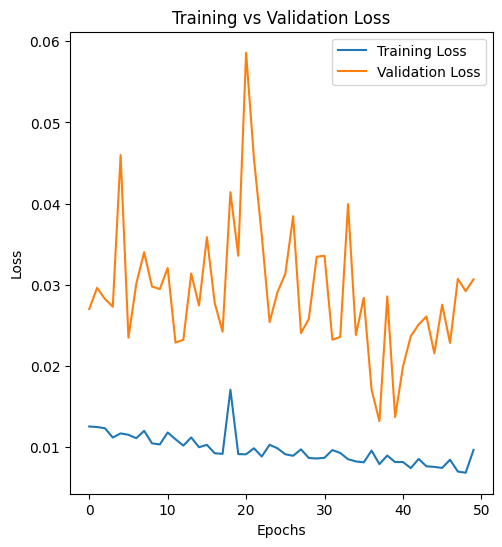

In [63]:
#model = Sequential()
#model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1.1e-2)))
#"model.add(Dense(3, activation='softmax'))


#best ones yet l1=1e-4, l2=1e-2
# Compile the model with F1 score for each category as a metric
#model.compile(loss='kl_divergence', optimizer='adam', metrics=[
#    'accuracy',
#   tfa.metrics.F1Score(num_classes=3, average=None)
#])

# Train the model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
#
# Evaluate the model
print(f"Evaluation of the model: ")
scores = best_model.evaluate(X_test, y_test)

# Access the F1 score for each category
f1_scores = scores[2:]  # Assuming they are the third metric onwards
print(f"F1 Scores for each category: {f1_scores}")

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [62]:
# Get the best models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=X_train.shape)

# Architecture of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (14253, 448)              5824      
                                                                 
 dense_1 (Dense)             (14253, 2)                898       
                                                                 
Total params: 6722 (26.26 KB)
Trainable params: 6722 (26.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
srrr = solo_shot.copy()
df1 = pd.DataFrame()
df1["Time"] = srrr["Time"]
srrr = scaler.fit_transform(solo_shot)

In [ ]:
# Get the best models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=X_train.shape)

# Architecture of the best model
best_model.summary()

In [64]:
# 'loaded_model' is our trained Keras model and 'X_data' our input data
probabilities = best_model.predict(srrr)
df1.reset_index(drop=True, inplace=True)
probabilities_df = pd.DataFrame(probabilities, columns=['No_Event', 'Event'])

# Merging the time data with the probabilities
merged_df = pd.concat([df1, probabilities_df], axis=1)

merged_df.head()

4/4 [==============================] - 0s 2ms/step


,Time,No_Event,Event
0,7.324,1.0,5.103875e-17
1,7.325,1.0,5.772405e-17
2,7.326,1.0,6.690107e-17
3,7.327,1.0,7.824990e-17
4,7.328,1.0,9.679839e-17


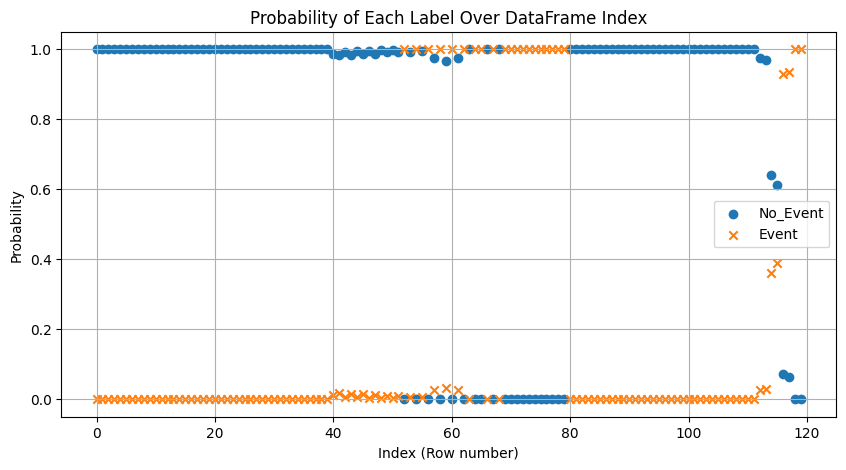

In [66]:
plt.figure(figsize=(10, 5))

# Scatter plot for 'No_Event'
plt.scatter(probabilities_df.index, probabilities_df['No_Event'], label='No_Event', marker='o')
# Scatter plot for 'Event'
plt.scatter(probabilities_df.index, probabilities_df['Event'], label='Event', marker='x')

# Adding labels, title, and legend
plt.xlabel('Index (Row number)')
plt.ylabel('Probability')
plt.title('Probability of Each Label Over DataFrame Index')
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()

In [ ]:
# Get the best models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=X_train.shape)

# Architecture of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (14114, 128)              1664      
                                                                 
 dense_1 (Dense)             (14114, 3)                387       
                                                                 
Total params: 2051 (8.01 KB)
Trainable params: 2051 (8.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate the model on the test set
scores = best_model.evaluate(X_test, y_test)
f1_scores = scores[2:]
print(f"F1 Scores for test set: {f1_scores}")

111/111 [==============================] - 0s 3ms/step - loss: 0.1086 - accuracy: 0.9627 - f1_score: 0.9223
F1 Scores for test set: [array([0.98456323, 0.9014926 , 0.8809524 ], dtype=float32)]


In [ ]:
best_model.save(filepath='/content/model.keras', overwrite=True, save_format='keras')

NameError: ignored

In [ ]:
loaded_model = tf.keras.models.load_model("model.keras")

In [ ]:
# Evaluate the model on the test set
scores = loaded_model.evaluate(X_test, y_test)
f1_scores = scores[2:]
print(f"F1 Scores for test set: {f1_scores}")

111/111 [==============================] - 1s 3ms/step - loss: 0.1086 - accuracy: 0.9627 - f1_score: 0.9223
F1 Scores for test set: [array([0.98456323, 0.9014926 , 0.8809524 ], dtype=float32)]


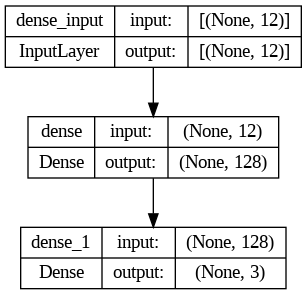